In [20]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from typing import Dict, List, Tuple
from dataclasses import dataclass

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = "data/housing_adequacy_dataset.csv"  # your saved dataset
SPLIT_POINT = "2020Q1"  # chronological split (train < split, test >= split)
PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]  # display order (edit if needed)
AHS = 2.5  # average household size (used in notes + future forecast)
RANDOM_STATE = 42

In [ ]:
# ----------------------------
# Utility: Metrics
# ----------------------------
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def smape(y_true, y_pred, eps=1e-12):
    # symmetric MAPE in percent (not multiplied by 100 here — we’ll multiply in table)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def mase(y_true, y_pred, y_train, seasonality=4):
    """
    Mean Absolute Scaled Error against seasonal naive (lag s).
    scale = mean absolute difference of training series with seasonal lag
    """
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality:
        return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) > 0 else np.nan
    if scale == 0 or np.isnan(scale):
        return np.nan
    return mae(y_true, y_pred) / scale


In [42]:

# ----------------------------
# EDA plotting helpers (matplotlib only)
# ----------------------------

PROVINCE_NAMES = {
    "can": "Canada",
    "nl": "Newfoundland and Labrador",
    "pe": "Prince Edward Island",
    "ns": "Nova Scotia",
    "nb": "New Brunswick",
    "qc": "Quebec",
    "on": "Ontario",
    "mb": "Manitoba",
    "sk": "Saskatchewan",
    "ab": "Alberta",
    "bc": "British Columbia",
}

def _to_datetime_from_period(q):
    """Convert quarterly PeriodIndex to Timestamp for plotting."""
    # period -> timestamp at period start (e.g., 1990Q1 -> 1990-01-01)
    return q.dt.to_timestamp()

def plot_time_series(
    df: pd.DataFrame,
    col: str,
    title: str,
    ncols: int = 3,
    provinces_order: List[str] = None,
    line_kw: dict = None,
    height_per_row: float = 2.6,
    width_per_col: float = 4.0,
    year_tick_interval: int = 2,  # every 2 years
    rotation: int = 60,           # rotate x-labels slightly
):
    """
    Faceted time-series plots by province with clean, tilted year ticks:
    - Concise or custom date formatter
    - Shared x-axis (labels only on bottom row)
    - Light grid + tight layout
    """
    if provinces_order is None:
        provinces = sorted(df["province"].unique())
    else:
        provinces = [p for p in provinces_order if p in df["province"].unique()]
    n = len(provinces)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(width_per_col * ncols, height_per_row * nrows),
        sharex=True,
    )
    axes = np.array(axes).reshape(nrows, ncols)

    # Tick locator: yearly, every 'year_tick_interval' years
    locator = mdates.YearLocator(base=year_tick_interval)
    formatter = mdates.DateFormatter('%Y')

    line_kw = {"linewidth": 1.6, "color": "tab:blue"} | (line_kw or {})

    for i, p in enumerate(provinces):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        sub = df[df["province"] == p].sort_values("quarter").copy()
        x = _to_datetime_from_period(sub["quarter"])
        y = sub[col].values

        ax.plot(x, y, **line_kw)
        ax.set_title(p, fontsize=10, pad=4)
        ax.grid(True, alpha=0.25)
        ax.margins(x=0.01)

        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

        # Rotate x-tick labels slightly for better separation
        for label in ax.get_xticklabels():
            label.set_rotation(rotation)
            label.set_ha("right")

        if r < nrows - 1:
            ax.tick_params(axis="x", labelbottom=False)

    # Hide unused panels
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    fig.suptitle(title, y=0.98, fontsize=12)
    fig.tight_layout()
    plt.show()

def plot_hist(df: pd.DataFrame, col: str, bins: int = 30, title: str = None):
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna().values, bins=bins)
    plt.title(title or f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_box_by_province(
    df: pd.DataFrame,
    col: str,
    title: str,
    provinces_order: List[str] = None,
    use_symlog: bool = True,
    linthresh: float = 1.0,      # linear region around 0 for symlog
    ylim_percentile: float = 99, # clip extreme outliers to keep the plot readable
):
    """
    Boxplots by province with:
      • full province names
      • optional symmetrical-log y-axis (handles negatives + positives)
      • optional percentile clipping of extreme outliers (visual only)
    """
    if provinces_order is None:
        provinces = sorted(df["province"].unique())
    else:
        provinces = [p for p in provinces_order if p in df["province"].unique()]

    labels = [PROVINCE_NAMES.get(p, p) for p in provinces]
    series = [df.loc[df["province"]==p, col].dropna() for p in provinces]

    # Percentile-based y clipping (visual only)
    all_vals = pd.concat(series) if len(series) else pd.Series(dtype=float)
    ylim = None
    if len(all_vals):
        lo = np.nanpercentile(all_vals, 100 - ylim_percentile) if ylim_percentile else None
        hi = np.nanpercentile(all_vals, ylim_percentile) if ylim_percentile else None
        if ylim_percentile:
            # symmetric clipping around 0 is not guaranteed, but we’ll just bound to [lo, hi]
            ylim = (lo, hi)

    plt.figure(figsize=(max(8, 0.5*len(labels)+6), 3.6))
    bp = plt.boxplot(
        series,
        labels=labels,
        showmeans=True,
        meanline=False,
        patch_artist=False,
        whis=(5,95),  # whiskers at 5th/95th percentiles (robust to outliers)
    )
    plt.xticks(rotation=20, ha="right")
    plt.ylabel(col)
    plt.title(title)

    ax = plt.gca()
    ax.grid(True, axis="y", alpha=0.3)

    if use_symlog:
        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)
        # add a faint line at y=0 to orient negative vs positive
        ax.axhline(0, color="grey", linewidth=0.8, alpha=0.5)

    if ylim is not None and np.all(np.isfinite(ylim)):
        # keep at least a small margin
        ax.set_ylim(ylim[0] - 0.05*abs(ylim[0]), ylim[1] + 0.05*abs(ylim[1]))

    plt.tight_layout()
    plt.show()

def corr_heatmap(df: pd.DataFrame, cols: List[str], title: str):
    """Correlation heatmap using matplotlib imshow."""
    sub = df[cols].dropna()
    if sub.empty:
        print(f"[Heatmap] No data for columns: {cols}")
        return
    corr = np.corrcoef(sub.values.T)
    plt.figure(figsize=(0.6*len(cols)+4, 0.6*len(cols)+4))
    im = plt.imshow(corr, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Feature Engineering
# ----------------------------
def add_lags(df: pd.DataFrame, cols: List[str], lags: List[int]) -> pd.DataFrame:
    df = df.sort_values(["province","quarter"]).copy()
    for col in cols:
        for l in lags:
            df[f"{col}_lag{l}"] = df.groupby("province")[col].shift(l)
    return df

def chronological_split(model_df: pd.DataFrame, split_point: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Train < split_point, Test >= split_point (per province already combined)."""
    train = model_df[model_df["quarter"] < split_point].copy()
    test  = model_df[model_df["quarter"] >= split_point].copy()
    return train, test

# ----------------------------
# Model Registry
# ----------------------------
def build_model_registry() -> Dict[str, Pipeline]:
    # Scale for linear models (not needed for trees, but OK to include selectively)
    models = {
        "lr": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                        ("model", LinearRegression())]),
        "ridge": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                           ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))]),
        "lasso": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                           ("model", Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000))]),
        "rf": RandomForestRegressor(
            n_estimators=500, max_depth=None, min_samples_split=2,
            min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "gbr": GradientBoostingRegressor(
            n_estimators=600, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE
        ),
    }
    # Wrap trees in Pipeline with no-op scaler? Not needed; use them directly.
    return models

# ----------------------------
# Training & Evaluation
# ----------------------------
def evaluate_models_per_province(
    df: pd.DataFrame,
    split_point: str,
    feature_cols: List[str],
    target_col: str = "starts_saar_q",
    seasonality: int = 4
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, pd.Series]]]:
    """
    Trains model registry per province, returns metrics table and predictions store.
    predictions_store[province][model_name] = pd.Series (aligned with test index)
    """
    models = build_model_registry()
    provinces = sorted(df["province"].unique(), key=lambda x: PROVINCES_ORDER.index(x) if x in PROVINCES_ORDER else 999)
    metrics_rows = []
    predictions_store = {}

    for p in provinces:
        sub = df[df["province"] == p].copy()
        # drop rows missing features/target
        sub_model = sub.dropna(subset=feature_cols + [target_col]).copy()
        if sub_model.empty:
            continue

        train, test = chronological_split(sub_model, split_point)
        if train.empty or test.empty:
            continue

        X_tr, y_tr = train[feature_cols].values, train[target_col].values
        X_te, y_te = test[feature_cols].values, test[target_col].values

        # Seasonal naive (lag s) baseline — aligns with MASE denominator idea
        # We'll also store it as a pseudo-model for reference
        naive_pred = test[f"{target_col}_lag{seasonality}"].values
        predictions_store.setdefault(p, {})["seasonal_naive"] = pd.Series(naive_pred, index=test.index)

        # Train/eval all models
        for name, model in models.items():
            mdl = model
            mdl.fit(X_tr, y_tr)
            yhat = mdl.predict(X_te)

            _mae = mae(y_te, yhat)
            _rmse = rmse(y_te, yhat)
            _smape = smape(y_te, yhat) * 100.0  # %
            _mase = mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)

            metrics_rows.append({
                "province": p, "model": name,
                "MAE": _mae, "RMSE": _rmse,
                "sMAPE(%)": _smape, "MASE": _mase
            })
            predictions_store[p][name] = pd.Series(yhat, index=test.index)

        # Record seasonal naive metrics, too
        _mae = mae(y_te, naive_pred)
        _rmse = rmse(y_te, naive_pred)
        _smape = smape(y_te, naive_pred) * 100.0
        _mase = mase(y_te, naive_pred, y_train=y_tr, seasonality=seasonality)
        metrics_rows.append({
            "province": p, "model": "seasonal_naive",
            "MAE": _mae, "RMSE": _rmse, "sMAPE(%)": _smape, "MASE": _mase
        })

    metrics_df = pd.DataFrame(metrics_rows).sort_values(["province","model"]).reset_index(drop=True)
    return metrics_df, predictions_store

# ----------------------------
# Future Forecast Scaffold
# ----------------------------
def forecast_future(
    trained_models: Dict[str, object],
    df_full: pd.DataFrame,
    future_df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = "starts_saar_q",
    province_col: str = "province",
    seasonality: int = 4
) -> pd.DataFrame:
    """
    Given: trained per-province models and a future_df with exogenous variables prepared,
    this will roll-forward lags from the last known history per province
    and generate forecasts for target_col.
    Assumes future_df contains columns: ['quarter','province','pop_change_q','needed_units_q', ... lag features will be filled here ...]
    """
    out = []
    # ensure order
    df_full = df_full.sort_values(["province","quarter"]).copy()
    future_df = future_df.sort_values(["province","quarter"]).copy()

    for p, g in future_df.groupby(province_col):
        hist = df_full[df_full[province_col]==p].copy().sort_values("quarter")
        # pick a model (you can change which one is "production")
        model = trained_models.get(p, {}).get("gbr", None) or trained_models.get(p, {}).get("rf", None)
        if model is None:
            continue

        # Fill lags iteratively across future horizon
        g = g.copy()
        # Start with last known lags from history
        for l in [1,2,3,4]:
            g[f"{target_col}_lag{l}"] = np.nan

        # Prepare rolling window of last 4 quarters
        last_vals = hist[target_col].tail(seasonality).tolist()

        preds = []
        for idx, row in g.iterrows():
            # set lagged target from buffer
            for l in [1,2,3,4]:
                val = last_vals[-l] if len(last_vals) >= l else np.nan
                g.at[idx, f"{target_col}_lag{l}"] = val

            # if you used lagged exogenous vars in training, add them similarly here (shift from g or hist)
            # Minimal version uses only contemporaneous exogenous + lagged target:
            X = g.loc[idx, feature_cols].values.reshape(1, -1)
            yhat = model.predict(X)[0]
            preds.append(yhat)

            # roll buffer
            last_vals.append(yhat)

        g["pred_"+target_col] = preds
        out.append(g)

    return pd.concat(out, axis=0).sort_values(["province","quarter"]).reset_index(drop=True)


In [43]:

# 1) Load
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}.\n",
        f> "Run your earlier script that saved df to this path, or update DATA_PATH."
    )
df = pd.read_csv(DATA_PATH)
# Ensure types
# quarter as Period (stored as string), make a sortable key also for plotting
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

In [44]:

# 2) Quick EDA
print("Dataset shape:", df.shape)
print(df.head(5))


Dataset shape: (1573, 9)
  quarter province  population  starts_saar  starts_saar_q  dwelling_starts  \
0  1990Q1       ab   2520056.0    23.421667       5.855417      5855.416667   
1  1990Q2       ab   2532621.0    21.490333       5.372583      5372.583333   
2  1990Q3       ab   2547788.0    13.847000       3.461750      3461.750000   
3  1990Q4       ab   2563142.0    11.723333       2.930833      2930.833333   
4  1991Q1       ab   2572947.0     8.494667       2.123667      2123.666667   

   pop_change_q  needed_units_q       hai  
0           NaN             NaN       NaN  
1       12565.0          5026.0  1.068958  
2       15167.0          6066.8  0.570606  
3       15354.0          6141.6  0.477210  
4        9805.0          3922.0  0.541475  


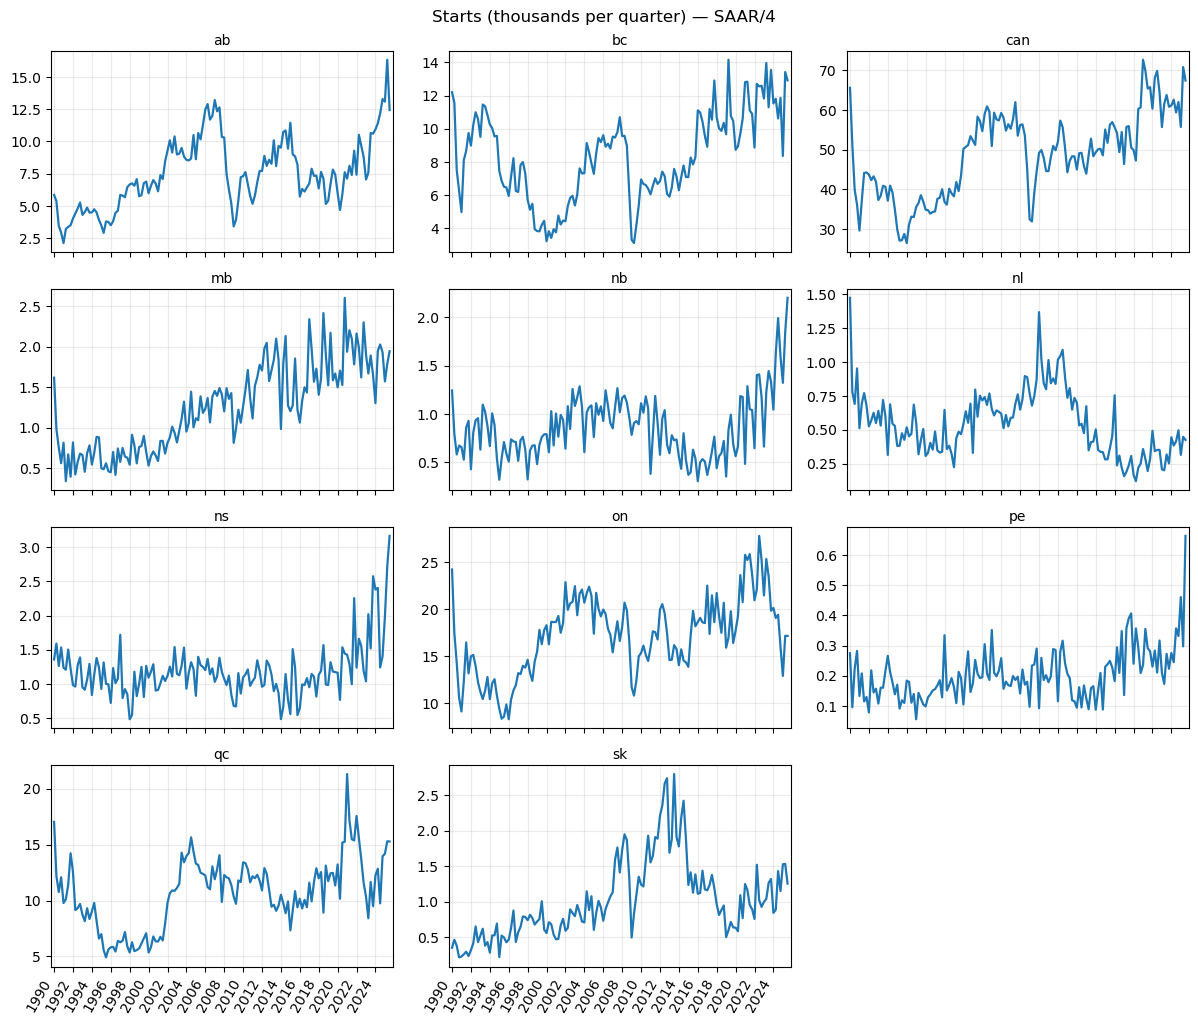

In [37]:

# Time series: starts, pop change, needed units, hai (diagnostic)
plot_time_series(df, "starts_saar_q", "Starts (thousands per quarter) — SAAR/4", ncols=3)


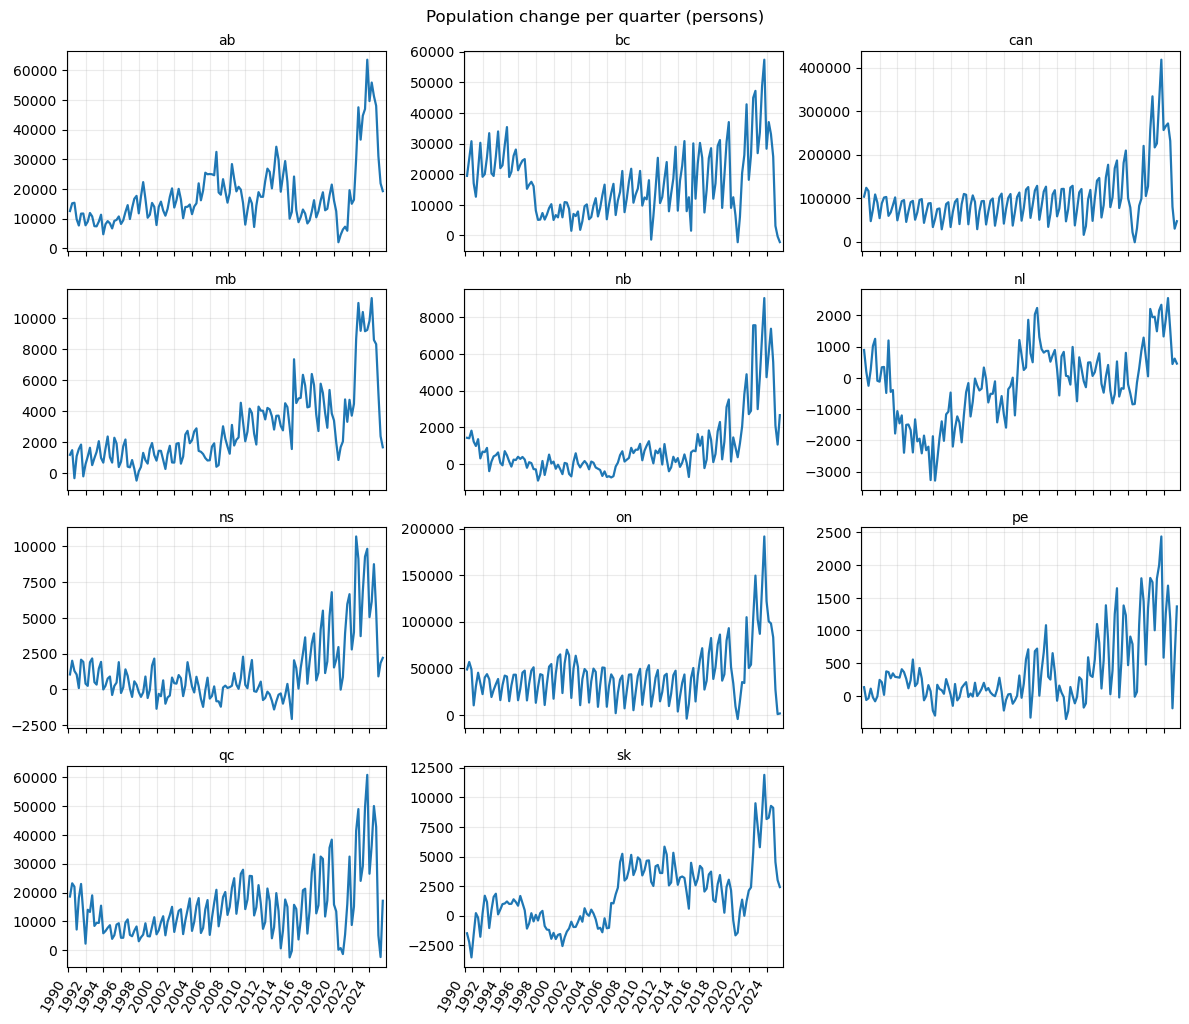

In [39]:
plot_time_series(df, "pop_change_q", "Population change per quarter (persons)", ncols=3)


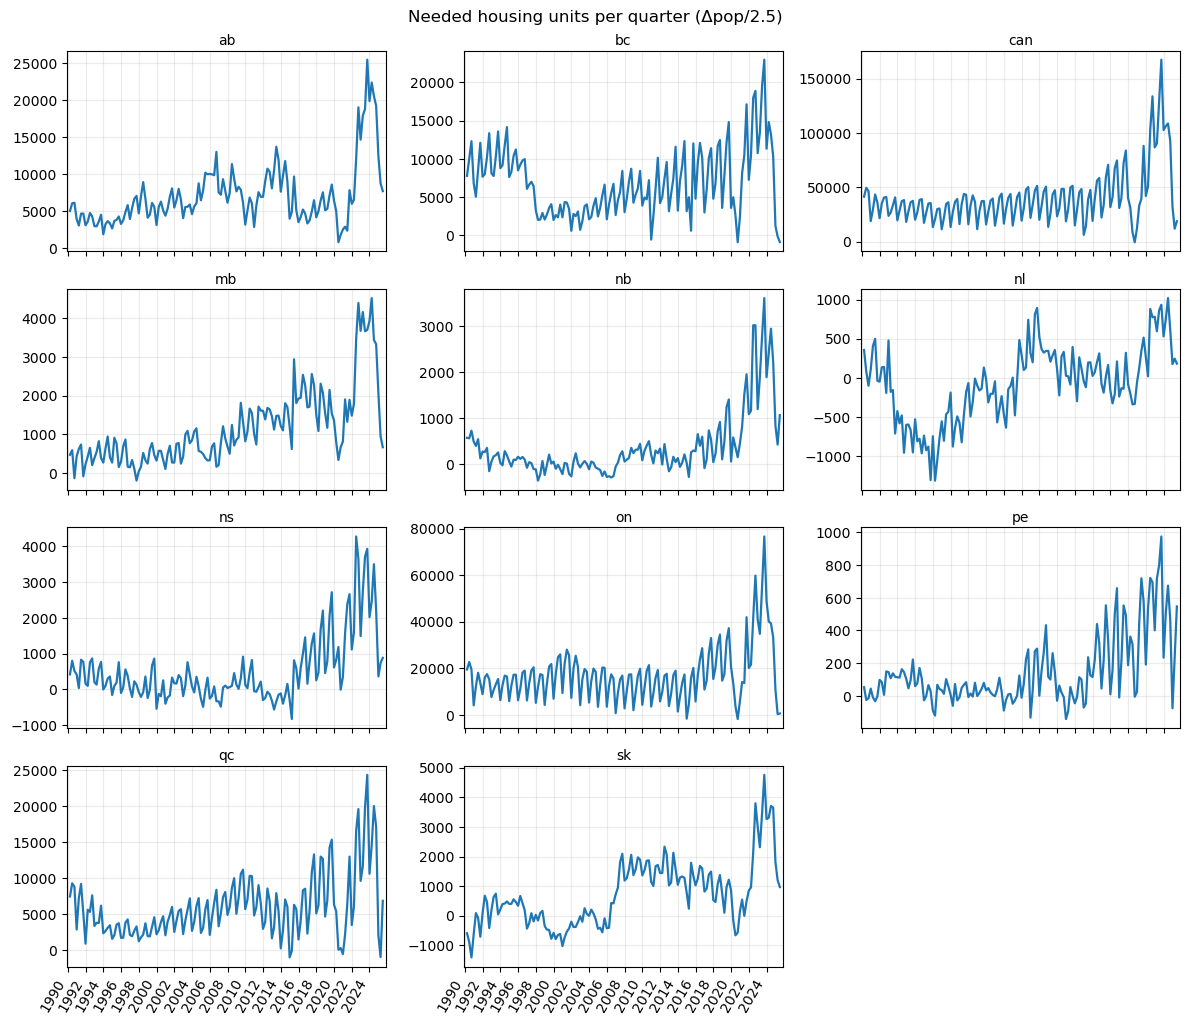

In [40]:
plot_time_series(df, "needed_units_q", f"Needed housing units per quarter (Δpop/{AHS})", ncols=3)


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_71342/880574606.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


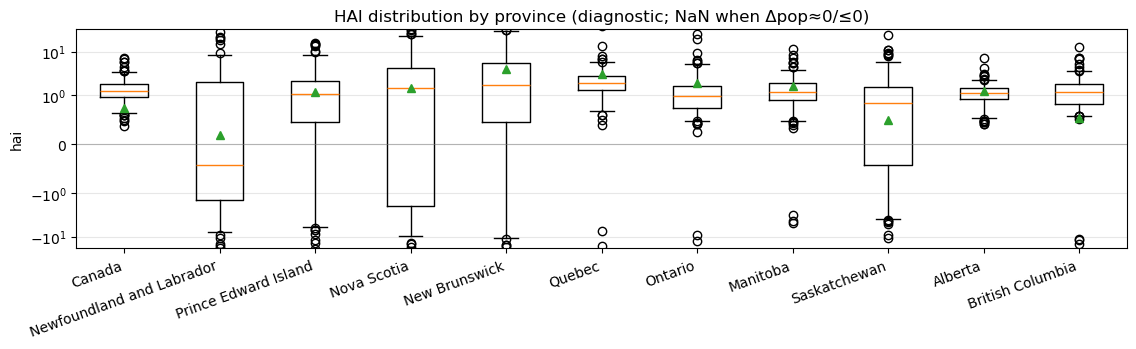

In [46]:
plot_box_by_province(
    df, 
    "hai",
    "HAI distribution by province (diagnostic; NaN when Δpop≈0/≤0)",
    provinces_order=PROVINCES_ORDER,
    use_symlog=True,    # handles negatives too
    linthresh=1.0,      # linear around [-1,1]
    ylim_percentile=99  # trims only the most extreme 1% tails
)

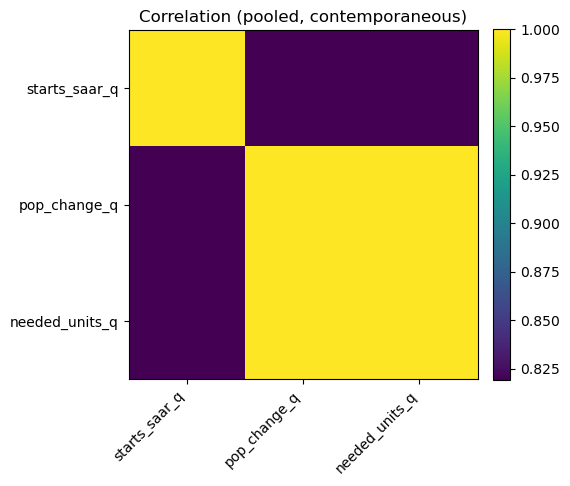

In [13]:

# Correlations (pooled) — choose core variables
corr_cols = ["starts_saar_q","pop_change_q","needed_units_q"]
# add lags once created — but first show contemporaneous
corr_heatmap(df, corr_cols, "Correlation (pooled, contemporaneous)")


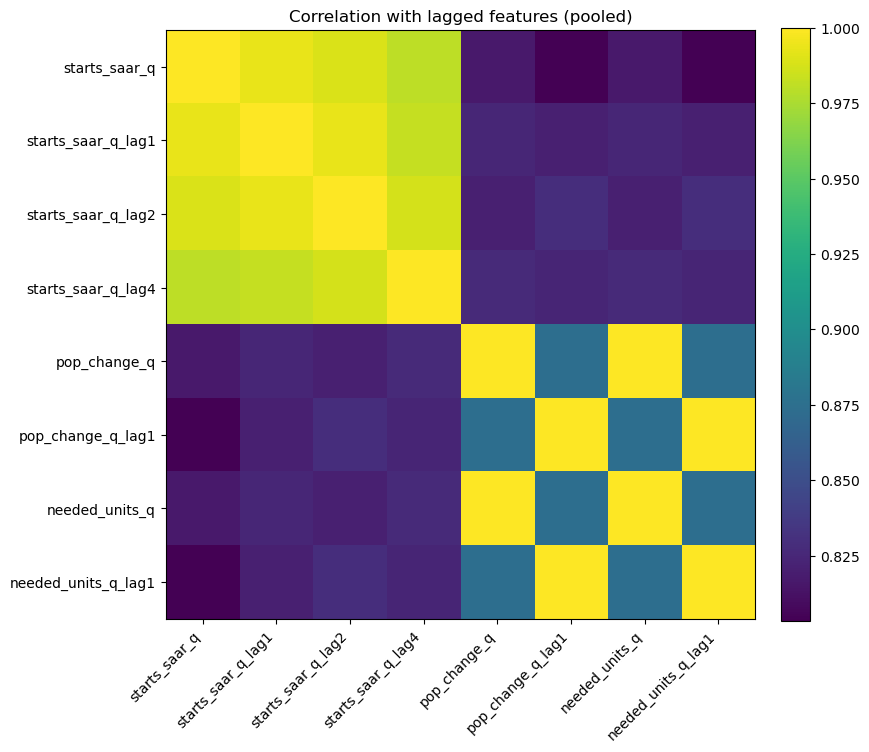

In [14]:

# 3) Feature Engineering: add lags (1,2,4) for key drivers + target
lag_cols = ["starts_saar_q","pop_change_q","needed_units_q"]
df_lag = add_lags(df, lag_cols, lags=[1,2,4])

# After lags, a richer correlation look (pooled)
corr_cols2 = ["starts_saar_q",
                "starts_saar_q_lag1","starts_saar_q_lag2","starts_saar_q_lag4",
                "pop_change_q","pop_change_q_lag1","needed_units_q","needed_units_q_lag1"]
corr_heatmap(df_lag, [c for c in corr_cols2 if c in df_lag.columns], "Correlation with lagged features (pooled)")


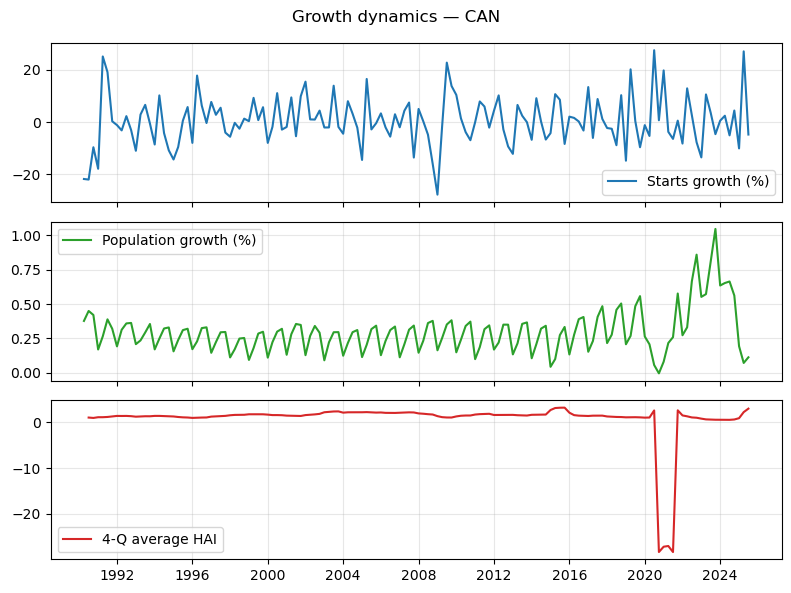

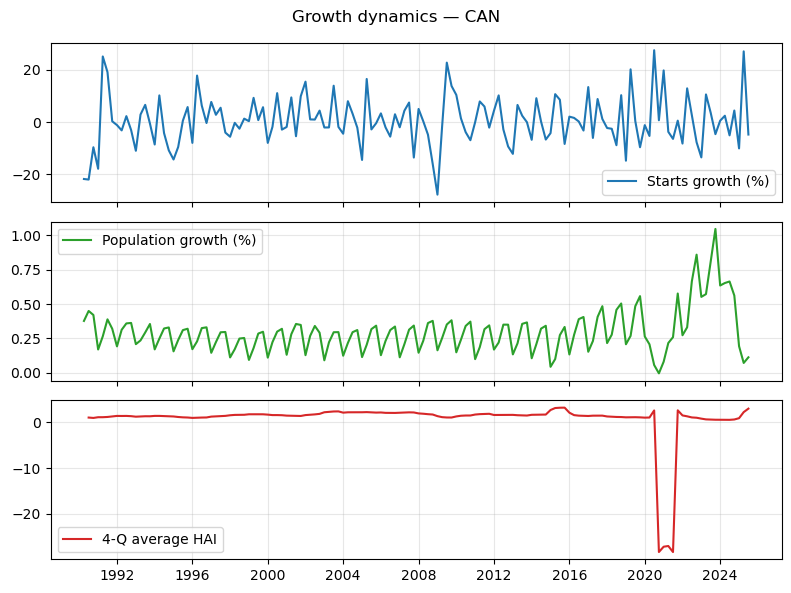

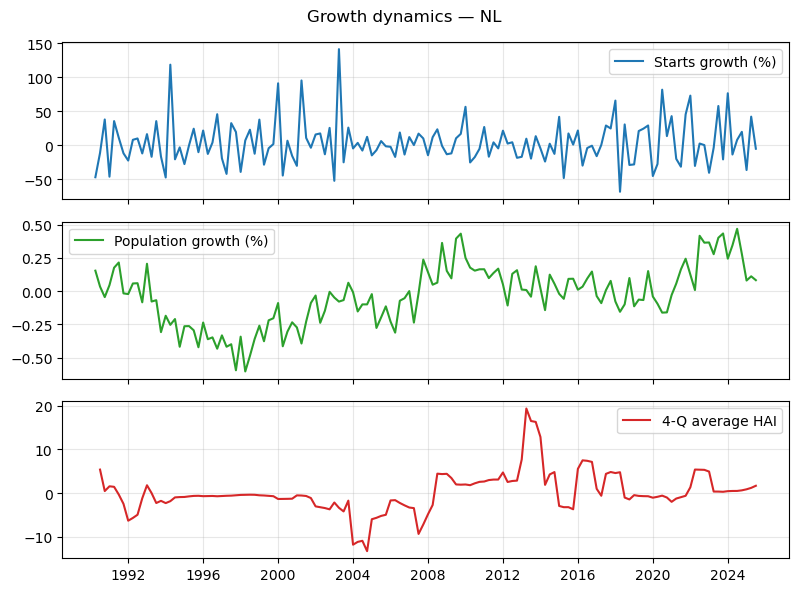

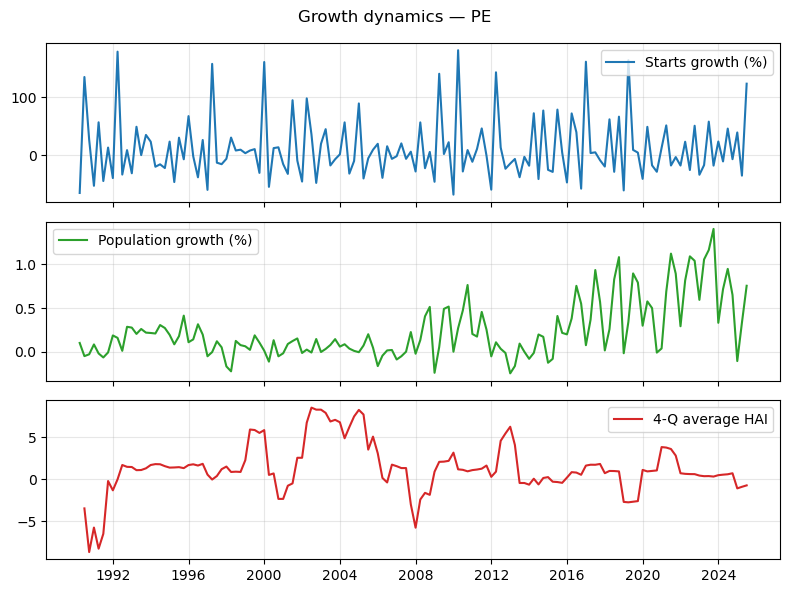

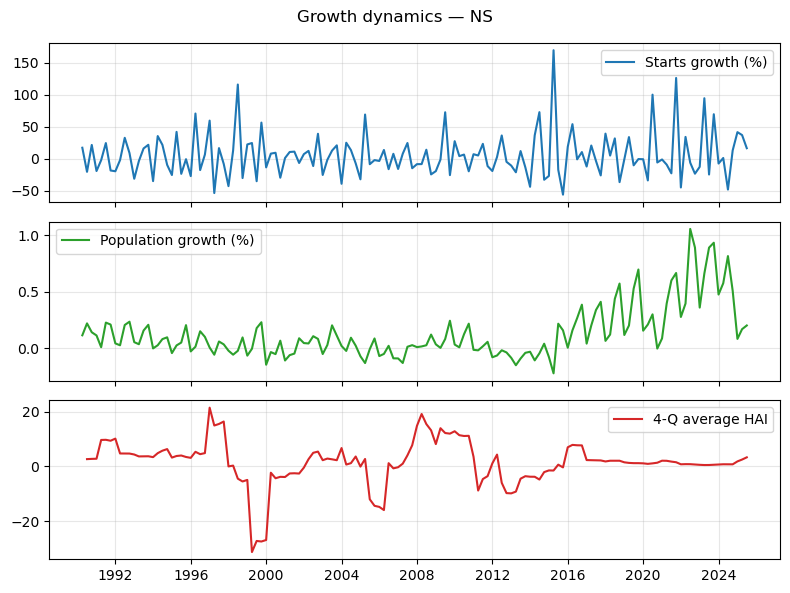

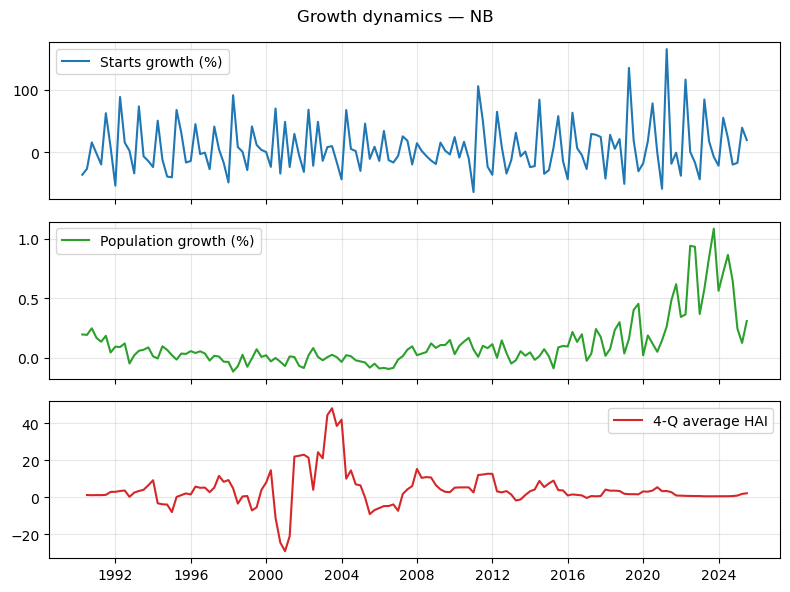

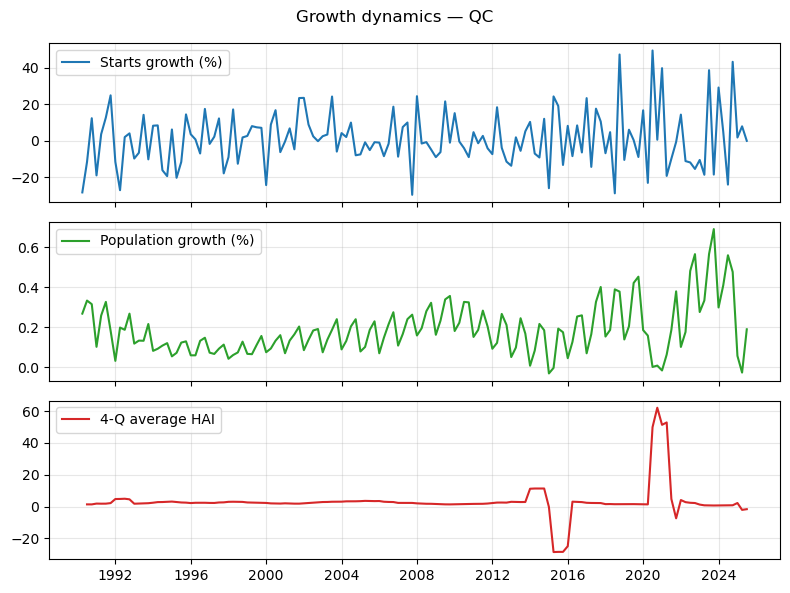

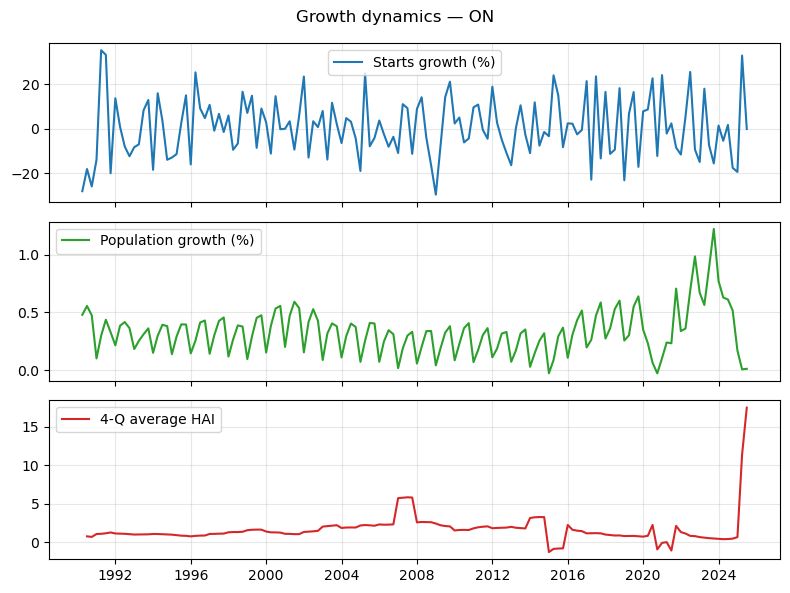

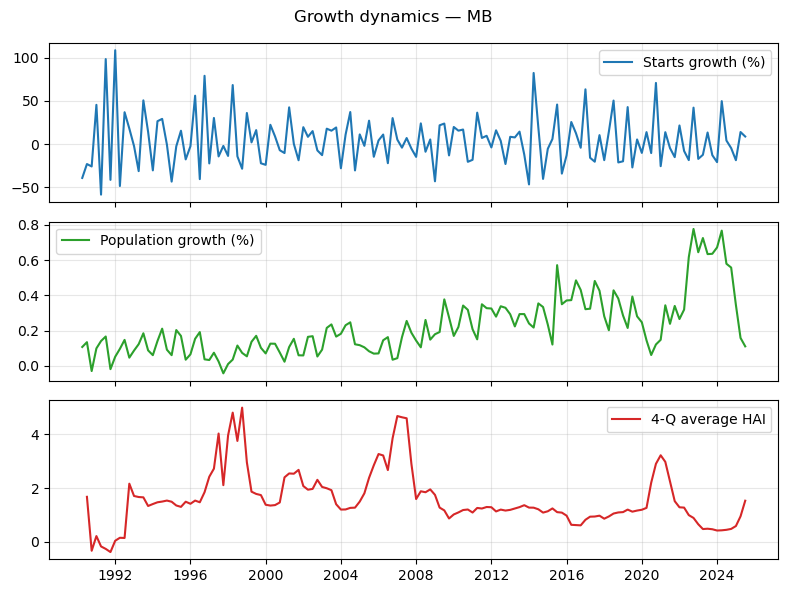

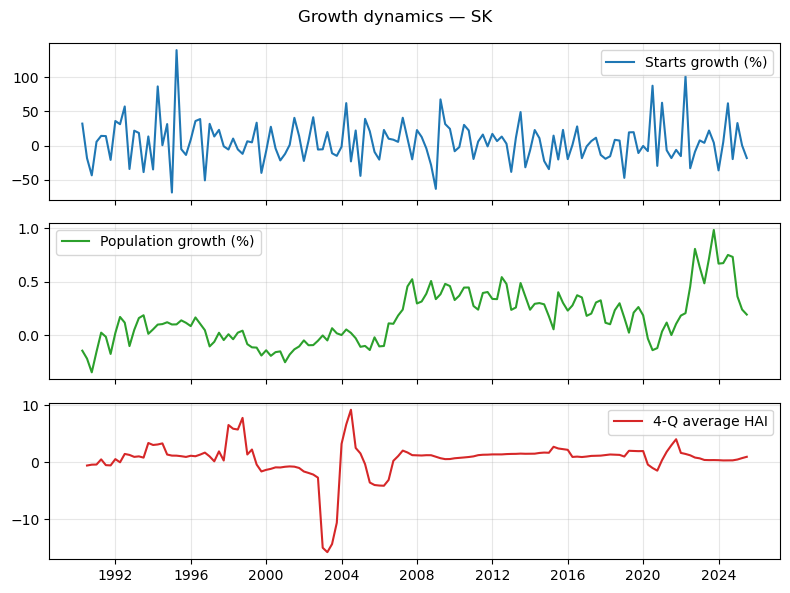

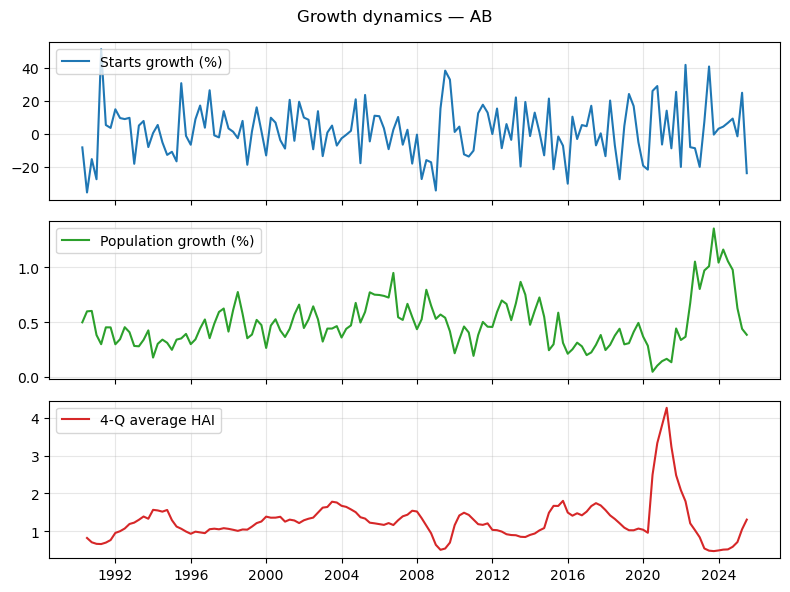

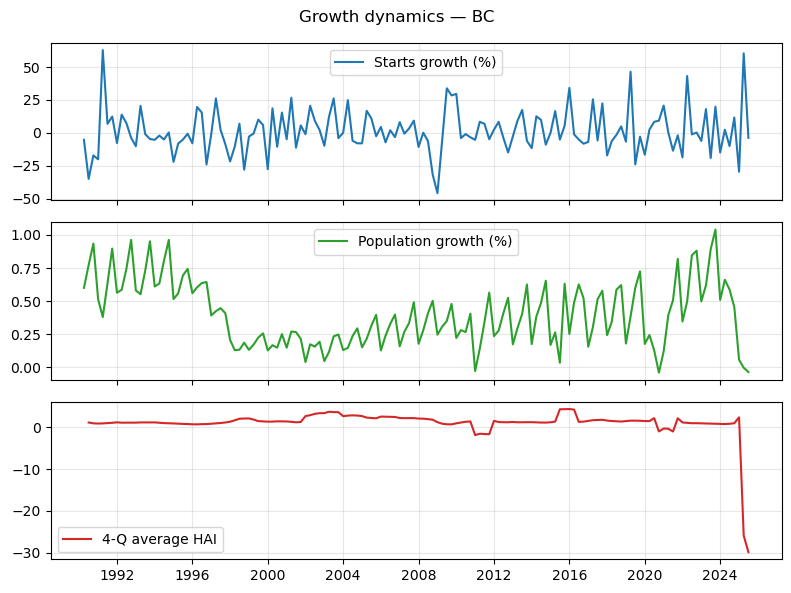

In [ ]:
# See how growth rates evolve and whether trends differ by province.
# Plot annualized growth rates of population vs. housing starts.
# Show rolling averages or trends (e.g. 4-quarter or 8-quarter moving means).

def plot_growth_rates(df, province="can"):
    sub = df[df["province"]==province].sort_values("quarter").copy()
    sub["starts_growth_%"] = sub["starts_saar_q"].pct_change() * 100
    sub["pop_growth_%"] = sub["population"].pct_change() * 100
    sub["rolling_hai"] = sub["hai"].rolling(4, min_periods=2).mean()

    fig, ax = plt.subplots(3,1,figsize=(8,6), sharex=True)
    x = sub["quarter"].dt.to_timestamp()
    ax[0].plot(x, sub["starts_growth_%"], label="Starts growth (%)")
    ax[1].plot(x, sub["pop_growth_%"], label="Population growth (%)", color="tab:green")
    ax[2].plot(x, sub["rolling_hai"], label="4-Q average HAI", color="tab:red")
    for a in ax: 
        a.grid(True, alpha=0.3)
        a.legend()
    fig.suptitle(f"Growth dynamics — {province.upper()}")
    plt.tight_layout()
    plt.show()
plot_growth_rates(df, province="can")  # Canada overall

for p in PROVINCES_ORDER:
    plot_growth_rates(df, province=p)

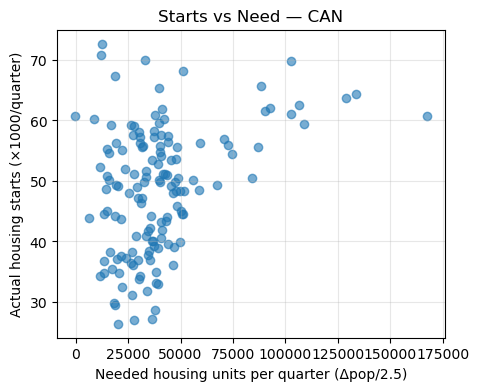

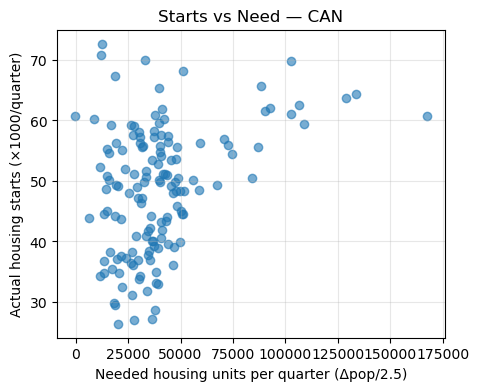

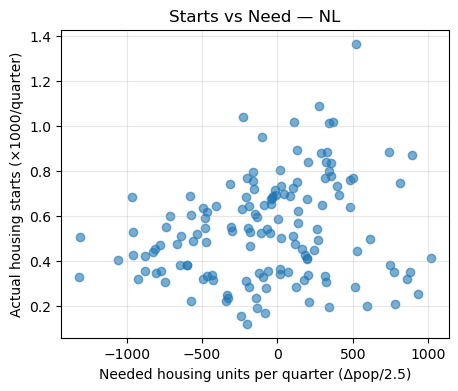

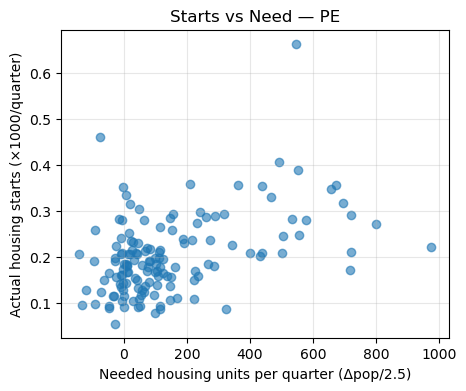

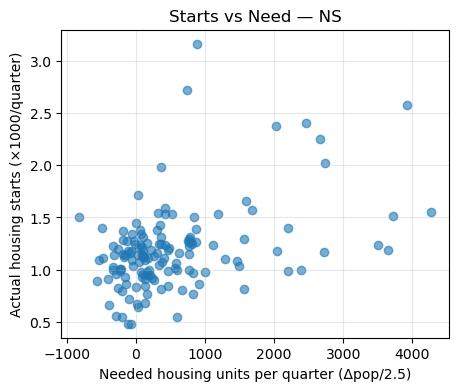

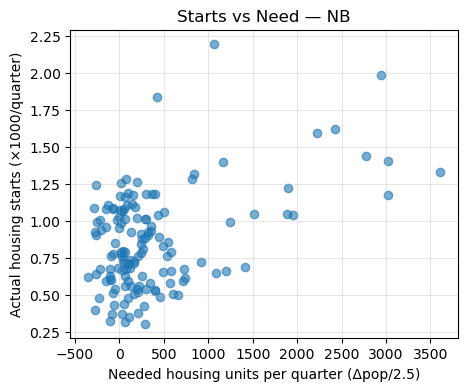

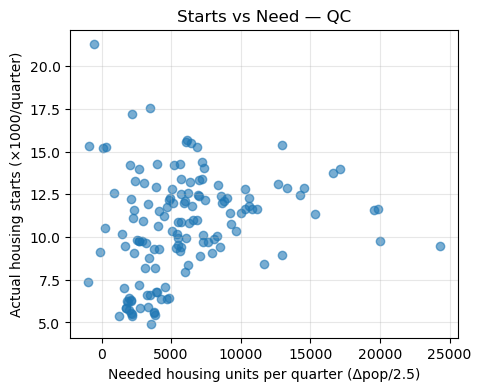

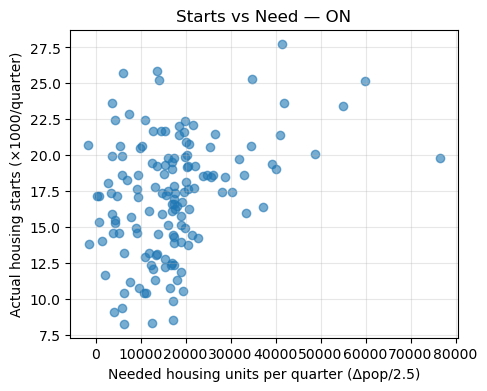

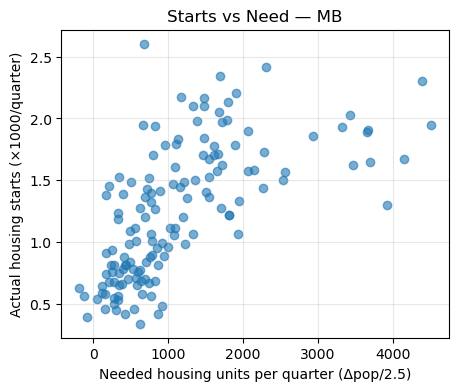

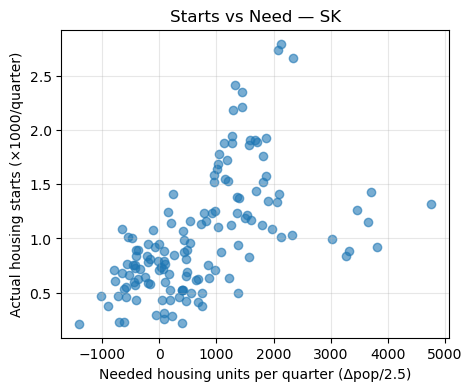

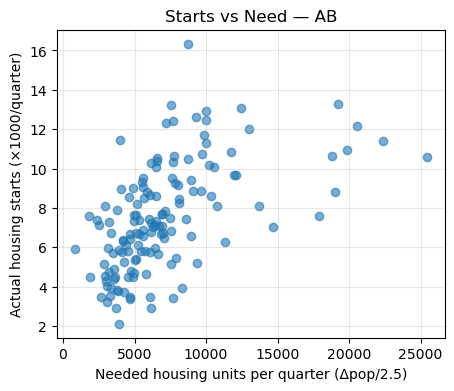

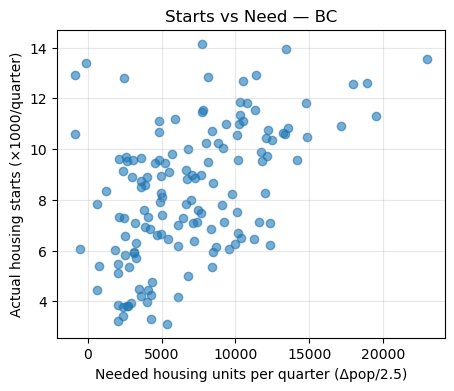

In [ ]:
# Check how strongly housing starts correlate with population growth, both contemporaneous and lagged.
def plot_scatter(df, province="can"):
    sub = df[df["province"]==province].dropna(subset=["starts_saar_q","pop_change_q","needed_units_q"])
    plt.figure(figsize=(5,4))
    plt.scatter(sub["needed_units_q"], sub["starts_saar_q"], alpha=0.6)
    plt.xlabel("Needed housing units per quarter (Δpop/2.5)")
    plt.ylabel("Actual housing starts (×1000/quarter)")
    plt.title(f"Starts vs Need — {province.upper()}")
    plt.grid(True, alpha=0.3)
    plt.show()
plot_scatter(df, province="can")  # Canada overall
for p in PROVINCES_ORDER:
    plot_scatter(df, province=p)

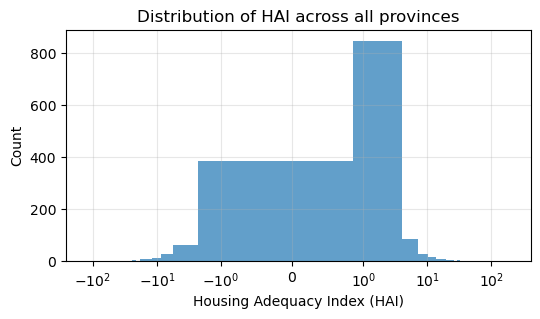

In [ ]:
#Distributional insight: HAI behaviour
def plot_hai_hist(df):
    plt.figure(figsize=(6,3))
    plt.hist(df["hai"].dropna(), bins=100, alpha=0.7)
    plt.xscale("symlog", linthresh=1)
    plt.xlabel("Housing Adequacy Index (HAI)")
    plt.ylabel("Count")
    plt.title("Distribution of HAI across all provinces")
    plt.grid(True, alpha=0.3)
    plt.show()
plot_hai_hist(df)

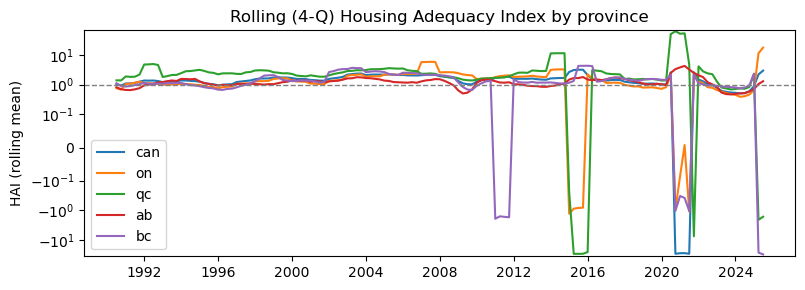

In [ ]:
#Relative adequacy trends (HAI over time): Assess when provinces move from shortage to surplus.
def plot_hai_trend(df, provinces=None):
    provinces = provinces or ["can","on","qc","ab","bc"]
    plt.figure(figsize=(8,3))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        plt.plot(sub["quarter"].dt.to_timestamp(), sub["hai"].rolling(4, min_periods=2).mean(), label=p)
    plt.axhline(1, color="gray", ls="--", lw=1)
    plt.legend()
    plt.title("Rolling (4-Q) Housing Adequacy Index by province")
    plt.ylabel("HAI (rolling mean)")
    plt.tight_layout()
    plt.yscale("symlog", linthresh=0.1)
    plt.show()
plot_hai_trend(df)

In [ ]:
#Summarize which provinces are persistently above/below adequacy threshold.
summary = (
    df.groupby("province")["hai"]
      .agg(["mean","median","std","count"])
      .assign(frac_above_1 = (df["hai"]>1).groupby(df["province"]).mean())
)
display(summary.sort_values("mean", ascending=False).round(2))

mean  median    std  count  frac_above_1
province                                          
nb        4.03    1.77  18.65    140          0.60
qc        3.01    1.90  19.88    142          0.88
on        1.91    0.98   4.73    142          0.48
mb        1.60    1.22   1.73    142          0.66
ns        1.50    1.48  14.41    140          0.55
ab        1.28    1.14   0.75    142          0.66
pe        1.21    1.10   4.64    123          0.45
can       0.74    1.29  10.53    142          0.72
bc        0.55    1.17   9.86    142          0.65
sk        0.51    0.85   5.67    140          0.42
nl        0.18   -0.42   7.81    140          0.34

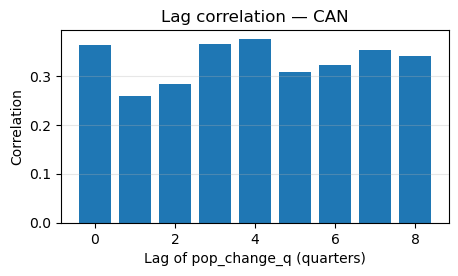

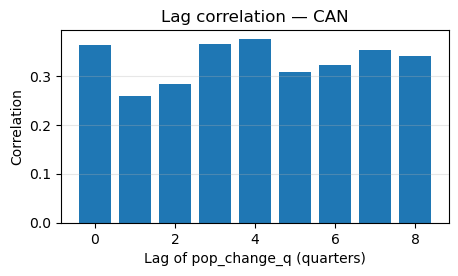

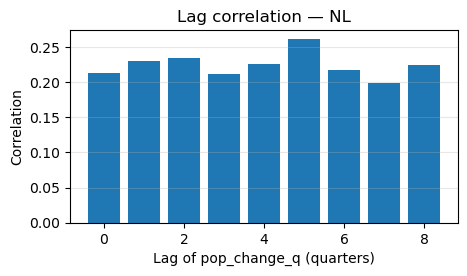

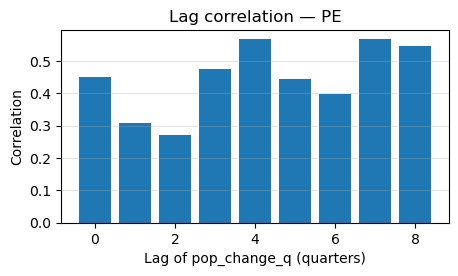

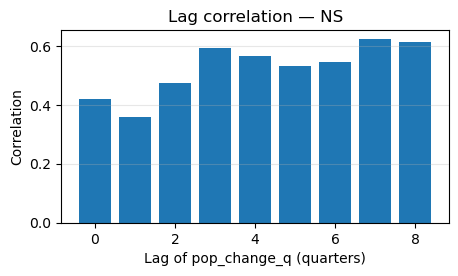

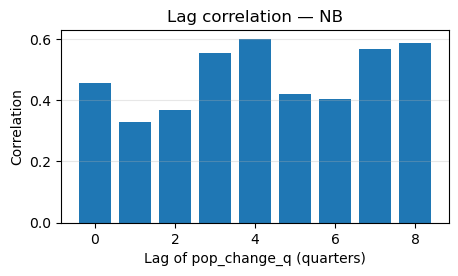

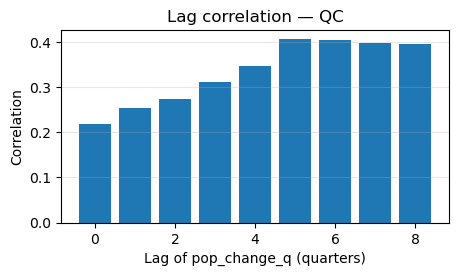

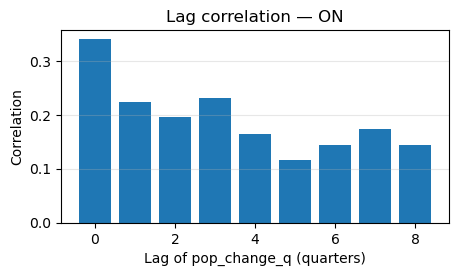

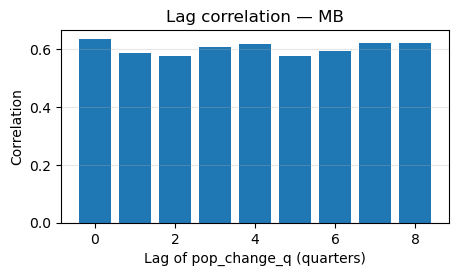

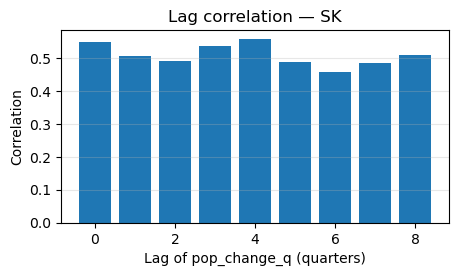

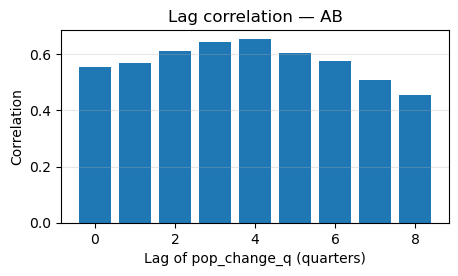

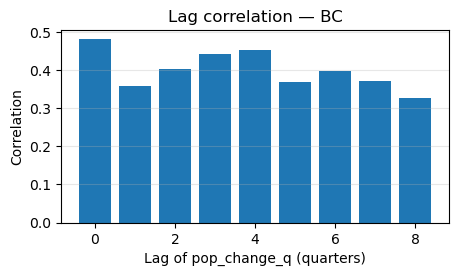

In [ ]:
#See whether housing starts react to population change with a lag.
def lag_corr(df, province="can", max_lag=8):
    sub = df[df["province"]==province].dropna(subset=["starts_saar_q","pop_change_q"])
    lags = range(0, max_lag+1)
    corr = [sub["starts_saar_q"].corr(sub["pop_change_q"].shift(l)) for l in lags]
    plt.figure(figsize=(5,2.5))
    plt.bar(lags, corr)
    plt.xlabel("Lag of pop_change_q (quarters)")
    plt.ylabel("Correlation")
    plt.title(f"Lag correlation — {province.upper()}")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()
lag_corr(df, province="can")  # Canada overall
for p in PROVINCES_ORDER:
    lag_corr(df, province=p)

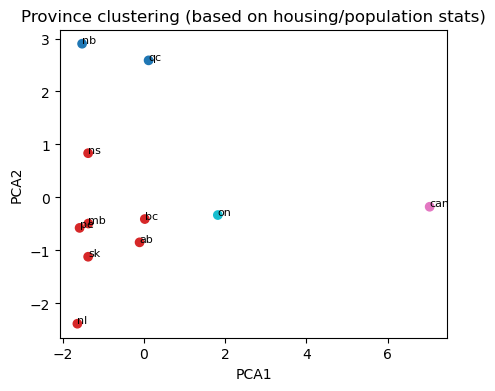

In [61]:
#Province clustering: Group provinces with similar housing–population dynamics.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

agg = (
    df.groupby("province")[["starts_saar_q","pop_change_q","hai"]]
      .agg(["mean","std","median"])
)
X = StandardScaler().fit_transform(agg.values)
pca = PCA(2)
coords = pca.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42).fit(coords)

plt.figure(figsize=(5,4))
plt.scatter(coords[:,0], coords[:,1], c=kmeans.labels_, cmap='tab10')
for i, label in enumerate(agg.index):
    plt.text(coords[i,0], coords[i,1], label, fontsize=8)
plt.title("Province clustering (based on housing/population stats)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()

In [62]:
#Seasonality & variance checks
df["quarter_num"] = df["quarter"].dt.quarter
seasonal_stats = (
    df.groupby(["province","quarter_num"])["starts_saar_q"]
      .agg(["mean","std"])
      .unstack(level=-1)
)
display(seasonal_stats.head())

mean                                         std             \
quarter_num          1          2          3          4          1          2   
province                                                                        
ab            7.177755   7.658500   7.557159   7.579833   2.790379   2.987955   
bc            7.782222   8.703444   8.484690   8.274343   2.620547   2.963259   
can          47.250556  49.188954  49.929729  48.323786  10.967874  11.186418   
mb            1.151854   1.262243   1.336906   1.242260   0.502701   0.545194   
nb            0.672472   0.902912   1.003020   0.878452   0.280538   0.335752   

                                  
quarter_num          3         4  
province                          
ab            2.562273  2.566327  
bc            2.405695  2.647588  
can          10.588596  9.712846  
mb            0.553954  0.552219  
nb            0.357110  0.253538

In [15]:

# 4) Define modeling frame
feature_cols = [
    "pop_change_q", "needed_units_q",
    "starts_saar_q_lag1", "starts_saar_q_lag2", "starts_saar_q_lag4",
    "pop_change_q_lag1", "needed_units_q_lag1"
]
target_col = "starts_saar_q"

model_df = df_lag.dropna(subset=feature_cols + [target_col]).copy()
print("Modeling rows after lag drop:", model_df.shape[0])


Modeling rows after lag drop: 1529


In [16]:

# 5) Train & Evaluate per province
metrics_df, preds_store = evaluate_models_per_province(
    model_df, split_point=SPLIT_POINT,
    feature_cols=feature_cols, target_col=target_col, seasonality=4
)


In [17]:

# 6) Summaries
print("\n=== Overall metrics (by province & model) ===")
print(metrics_df.head(20))

# Best model per province by RMSE
best_by_rmse = metrics_df.sort_values(["province","RMSE"]).groupby("province").head(1)
print("\n=== Best model per province (by RMSE) ===")
print(best_by_rmse[["province","model","MAE","RMSE","sMAPE(%)","MASE"]])

# Aggregate by model across provinces
agg = metrics_df.groupby("model").agg({"MAE":"mean","RMSE":"mean","sMAPE(%)":"mean","MASE":"mean"}).sort_values("RMSE")
print("\n=== Average metrics across provinces (lower is better) ===")
print(agg)



=== Overall metrics (by province & model) ===
   province           model       MAE       RMSE   sMAPE(%)      MASE
0        ab             gbr  1.502914   1.893972  17.677482  1.038061
1        ab           lasso  1.446598   1.741308  16.541168  0.999164
2        ab              lr  1.448309   1.742853  16.560875  1.000346
3        ab              rf  1.524657   1.914154  17.536317  1.053079
4        ab           ridge  1.444928   1.737710  16.527211  0.998011
5        ab  seasonal_naive  1.880183   2.272287  21.380136  1.298641
6        bc             gbr  1.313453   1.682643  11.798942  0.955762
7        bc           lasso  1.280362   1.727378  11.516719  0.931683
8        bc              lr  1.279585   1.726696  11.509426  0.931117
9        bc              rf  1.411394   1.762433  12.668879  1.027031
10       bc           ridge  1.281717   1.707740  11.518688  0.932669
11       bc  seasonal_naive  1.847366   2.302431  16.484359  1.344275
12      can             gbr  9.422293  10.5

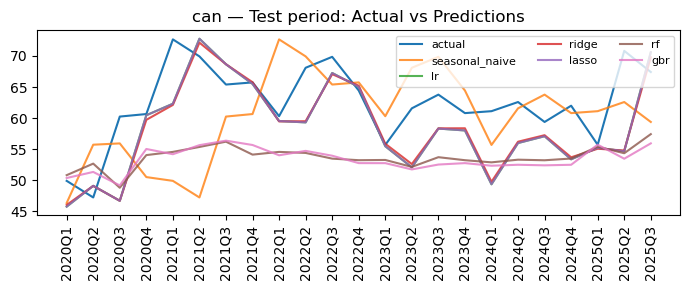

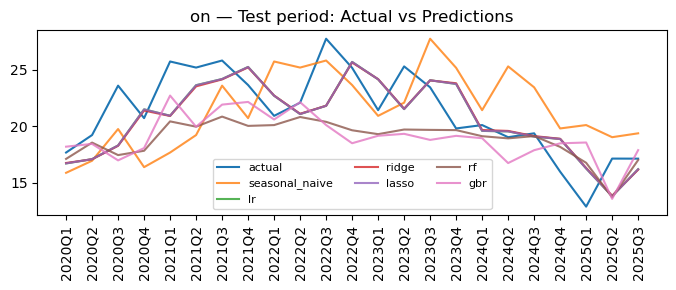

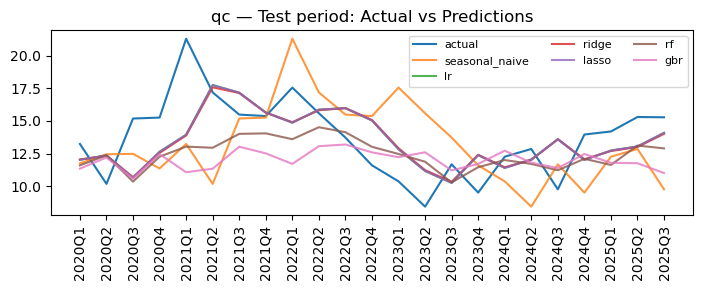

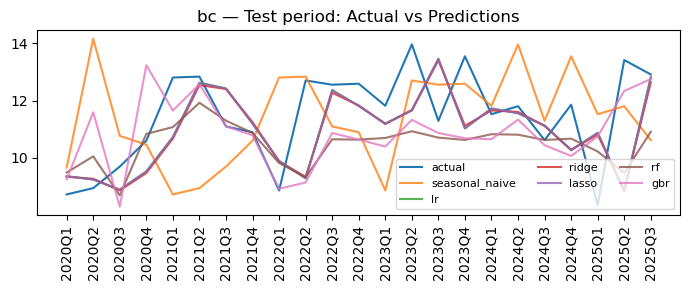

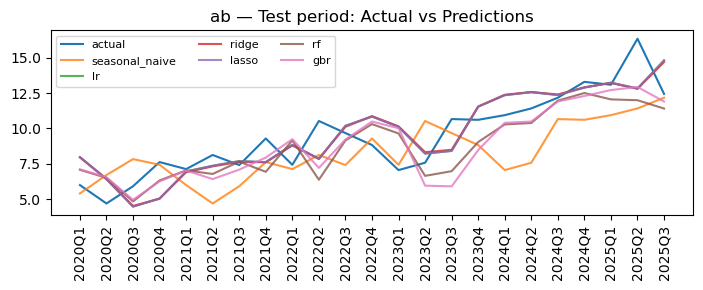

In [18]:

# 7) (Optional) Plot predictions vs actuals for a couple of provinces
for p in [x for x in ["can","on","qc","bc","ab"] if x in preds_store]:
    # find test slice index for any model
    any_model = next(iter(preds_store[p]))
    test_idx = preds_store[p][any_model].index
    sub = model_df.loc[test_idx].copy().sort_values("quarter")
    plt.figure(figsize=(7,3))
    plt.plot(sub["quarter"].astype(str), sub[target_col].values, label="actual")
    for name, pred_ser in preds_store[p].items():
        plt.plot(sub["quarter"].astype(str), pred_ser.values, label=name, alpha=0.8)
    plt.title(f"{p} — Test period: Actual vs Predictions")
    plt.xticks(rotation=90)
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()


In [ ]:

# 8) (Optional) Future forecast scaffold usage (requires your StatsCan future population projection)

# Example usage (pseudo — you must prepare future_pop_df with columns: quarter, province, population)
# future_pop_df = ...  # your StatsCan projections aligned to quarterly PeriodIndex
# future_pop_df = future_pop_df.sort_values(["province","quarter"]).copy()
# future_pop_df["pop_change_q"] = future_pop_df.groupby("province")["population"].diff()
# future_pop_df["needed_units_q"] = future_pop_df["pop_change_q"] / AHS

# # Attach last known lags from model_df, then call forecast_future
# # First, pick a production model per province (here: use GradientBoosting if available, else RF)
# trained_models = {}
# # Refit on full history per province using chosen model (e.g., 'gbr'):
# reg = build_model_registry()
# for p in model_df["province"].unique():
#     sub = model_df[model_df["province"]==p].dropna(subset=feature_cols + [target_col]).copy()
#     if sub.empty:
#         continue
#     # choose your production model
#     prod_name = "gbr" if "gbr" in reg else "rf"
#     mdl = reg[prod_name]
#     mdl.fit(sub[feature_cols].values, sub[target_col].values)
#     trained_models.setdefault(p, {})[prod_name] = mdl

# future_df = future_pop_df.copy()
# # ensure the feature columns exist (lags for target are filled inside forecast loop)
# for c in feature_cols:
#     if c not in future_df.columns:
#         # we only explicitly need contemporaneous exogenous here; lagged exog are optional
#         if "_lag" in c:
#             future_df[c] = np.nan
#         else:
#             raise ValueError(f"Future DF missing required feature: {c}")

# preds_future = forecast_future(
#     trained_models=trained_models,
#     df_full=model_df,
#     future_df=future_df,
#     feature_cols=feature_cols,
#     target_col=target_col,
#     province_col="province",
#     seasonality=4
# )
# # Adequacy forecast (if you want it on same unit logic):
# # starts_saar_q is in thousands of dwellings/quarter (since SAAR/4).
# # If you want dwellings/quarter as a count, multiply by 1000.
# preds_future["pred_dwelling_starts"] = preds_future["pred_"+target_col] * 1000.0
# preds_future["hai_pred"] = preds_future["pred_dwelling_starts"] / preds_future["needed_units_q"]
# print(preds_future.head())



AttributeError: 'ellipsis' object has no attribute 'sort_values'